# Human-Mammalian Brain - Basal Ganglia Patchseq

The basal ganglia (BG) constitute a system of interconnected brain structures that play a crucial role in motor control, learning, behavior, and emotion. These structures are implicated in numerous disorders affecting human health, including Parkinson’s disease, Huntington’s disease, and substance abuse disorders. Despite their importance, little is known about the cellular-level functional properties of the BG in humans and translationally relevant primate species. To address this gap, we performed Patch-seq experiments – integrating patch clamp electrophysiology with single cell RNA-sequencing anchored in the high-resolution, cross-species HMBA consensus basal ganglia cell type taxonomy. This approach enables us to reveal the morpho-electric properties of transcriptomically-defined striatal cell types in primates. Following electrophysiological characterization, nuclei were aspirated for RNA sequencing (SMART-Seq v4), and transcriptomic profiles were mapped to the consensus taxonomy. Each sample was assigned spatial coordinates within an anatomical reference, and cells with high-quality fills and mappings were subsequently reconstructed to obtain morphological features. The data derive from macaque (Macaca mulatta and Macaca nemestrina) striatal tissue obtained through a Tissue Distribution Program. These data are directly comparable to mouse basal ganglia datasets collected using the same protocols.  

Patch-seq samples were mapped to striatal neuronal types using the Hierarchical Approximate Nearest Neighbor (HANN) method implemented in the [Allen Institute MapMyCells package](https://brain-map.org/bkp/analyze/mapmycells), excluding non-neuronal types. After applying quality control to the mapping results, 717 macaque samples were retained. For more information on the taxonomy, please refer to the following webpage: [Mammalian Basal Ganglia Consensus Cell Type Atlas](https://alleninstitute.github.io/HMBA_BasalGanglia_Consensus_Taxonomy/). Additionally, you can see the associated notebooks linked at the end of this page. 

In this notebook, we'll look at gene expression for these 717 Macaque cells for different regions and taxonomy assignments. We'll also look at the electrophysiology and morphology summary stats as a function of the taxonomy. 

You need to be connected to the internet to run this notebook and have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [1]:
from typing import List, Tuple, Optional

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve a up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing the cache if it has not already been.

**Change the download_base variable to where you would like to download the data in your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
)

abc_cache.current_manifest

'releases/20260228/manifest.json'

## Cell metadata

Below we load the metadata associated with the individual patchseq cells and donor and library metadata. We join the donor and library data into the cell_metadata, this gives us e.g. donor_sex, donor_age information and region of interest labels from the library information.

In [3]:
macaque_cell_metadata = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='cell_metadata',
    dtype={"cell_label": str}
).set_index('cell_label')

macaque_donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='donor'
).set_index('donor_label')

macaque_library = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='library'
).set_index('library_label')

macaque_cell_metadata = macaque_cell_metadata.join(macaque_donor, on='donor_label', rsuffix='_donor')
macaque_cell_metadata = macaque_cell_metadata.join(macaque_library, on='library_label', rsuffix='_library')
macaque_cell_metadata.head()

cell_metadata.csv: 100%|██████████| 109k/109k [00:00<00:00, 998kMB/s]
donor.csv: 100%|██████████| 6.56k/6.56k [00:00<00:00, 77.2kMB/s]
library.csv: 100%|██████████| 142k/142k [00:00<00:00, 919kMB/s]  


,library_label,library_aliquot_label,barcoded_cell_sample_label,donor_label,dataset_label,feature_matrix_label,alignment_id,donor_age_value,donor_age_unit,age_at_death_reference_point,...,library_aliquot_label_library,barcoded_cell_sample_label_library,barcoded_cell_sample_technique,amplified_cdna_label,tissue_sample_local_name,donor_label_library,region_of_interest_label,region_of_interest_id,library_aliquot_nhash_id,library_nhash_id
cell_label,,,,,,,,,,,,,,,,,,,,,
QN22.26.002.14.05.04,L8S4_220222_04_H05,AB-S40302_S424_E1-50,P4S4_220131_155_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710839,15,years,birth,...,AB-S40302_S424_E1-50,P4S4_220131_155_A01,PatchSeq-SmartSeq,A8S4_220215_06_H05,QN22.26.002.14.05,QN22.26.002,Ca,HOMBA:10334,LA-JEACHN795730XCYBFE242803,LI-JEACHN795730
QN22.26.002.14.05.05,L8S4_220222_04_A06,AB-S40302_S425_E1-50,P4S4_220131_156_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710837,15,years,birth,...,AB-S40302_S425_E1-50,P4S4_220131_156_A01,PatchSeq-SmartSeq,A8S4_220215_06_A06,QN22.26.002.14.05,QN22.26.002,Ca,HOMBA:10334,LA-WCXYWT453000XCYBFE242803,LI-WCXYWT453000
QN22.26.002.14.05.06,L8S4_220222_04_B06,AB-S40302_S426_E1-50,P4S4_220131_157_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710836,15,years,birth,...,AB-S40302_S426_E1-50,P4S4_220131_157_A01,PatchSeq-SmartSeq,A8S4_220215_06_B06,QN22.26.002.14.05,QN22.26.002,Ca,HOMBA:10334,LA-JMJMOH539975XCYBFE242803,LI-JMJMOH539975
QN22.26.002.14.05.08,L8S4_220222_04_C06,AB-S40302_S427_E1-50,P4S4_220131_158_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710835,15,years,birth,...,AB-S40302_S427_E1-50,P4S4_220131_158_A01,PatchSeq-SmartSeq,A8S4_220215_06_C06,QN22.26.002.14.05,QN22.26.002,Ca,HOMBA:10334,LA-NJMQPI138328XCYBFE242803,LI-NJMQPI138328
QN22.26.002.14.05.09,L8S4_220222_04_D06,AB-S40302_S428_E1-50,P4S4_220131_159_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710834,15,years,birth,...,AB-S40302_S428_E1-50,P4S4_220131_159_A01,PatchSeq-SmartSeq,A8S4_220215_06_D06,QN22.26.002.14.05,QN22.26.002,Ca,HOMBA:10334,LA-HIEYXR972206XCYBFE242803,LI-HIEYXR972206


We load a value set table that defines colors for various features in the dataset as well as orders for those feature terms. We use these orders later in this notebook.

In [4]:
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='value_sets'
).set_index('label')
value_sets

value_sets.csv: 100%|██████████| 1.68k/1.68k [00:00<00:00, 26.1kMB/s]


,table,field,description,order,external_identifier,parent_label,color_hex_triplet
label,,,,,,,
Female,donor,donor_sex,Female,1,NaN,NaN,#565353
Male,donor,donor_sex,Male,2,NaN,NaN,#ADC4C3
Human,donor,species_genus,Human,1,NCBITaxon:9605,NaN,#377eb8
Macaque,donor,species_genus,Macaque,2,NCBITaxon:9539,NaN,#4daf4a
Marmoset,donor,species_genus,Marmoset,3,NCBITaxon:9481,NaN,#FF5F5D
Squirrel monkey,donor,species_genus,Squirrel monkey,4,NCBITaxon:9520,NaN,#ffa300
Mouse,donor,species_genus,Mouse,5,NCBITaxon:10088,NaN,#c941a7
Homo sapiens,donor,species_scientific_name,Homo sapiens,1,NCBITaxon:9606,NaN,#377eb8
Macaca mulatta,donor,species_scientific_name,Macaca mulatta,2,NCBITaxon:9544,NaN,#4daf4a


We define a convenience function to add colors for the various values in the data (e.g. unique region of interest or donor sex values).

In [5]:
def extract_value_set(cell_metadata_df: pd.DataFrame, input_value_set: pd.DataFrame, input_value_set_label: str):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The column name to extract color and order information for. The information will then be added to
        the cell metadata.
    """
    cell_metadata_df[f'{input_value_set_label}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['color_hex_triplet'].values
    cell_metadata_df[f'{input_value_set_label}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['order'].values

Use our function to add the relevant color and order columns to our cell_metadata table.

In [6]:
# Add region of interest color and order
extract_value_set(macaque_cell_metadata, value_sets, 'region_of_interest_label')

## Gene expression data

Now we extract expression for specific genes from the h5ad files and pair it with our gene metadata. In general, we can use the function `get_gene_data` to extract the expression of specific genes for all the cells in a given dataset or a subset of cells. For more details on using this convenience function, see the [Accessing 10x RNA-seq gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial notebook.

For this tutorial we will use precomputed tables of the expression for specific genes to compare expression by spatial location or by transcriptomic group.

To use the gene expression data, we first load the set of genes for the patch-seq data.

In [7]:
macaque_genes = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='gene',
).set_index('gene_identifier')
macaque_genes.head()

gene.csv: 100%|██████████| 3.33M/3.33M [00:00<00:00, 9.36MMB/s]


,gene_symbol,description,gene_id,molecular_type,synonym
gene_identifier,,,,,
NCBIGene:712737,A1BG,alpha-1-B glycoprotein,712737,protein_coding,[]
NCBIGene:703806,A1CF,APOBEC1 complementation factor,703806,protein_coding,[]
NCBIGene:716616,A2ML1,alpha-2-macroglobulin like 1,716616,protein_coding,[]
NCBIGene:711045,A3GALT2,"alpha 1,3-galactosyltransferase 2",711045,protein_coding,[]
NCBIGene:710998,A4GALT,"alpha 1,4-galactosyltransferase",710998,protein_coding,[]


Below we list the genes we will use in this notebook and the example method used to load the expression for these specific genes from the h5ad file. More details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [8]:
gene_names = ["WFS1", "CNR1", "CHRM3", "MYO16", "PTHLH", "DRD1", "DRD2", "TAC3", "SST"] 

macaque_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=macaque_cell_metadata,
    all_genes=macaque_genes,
    selected_genes=gene_names,
    data_type='log2'
)
macaque_gene_data.head()

loading file: HMBA-Macaque-PatchSeq-BG


HMBA-Macaque-PatchSeq-BG-log2.h5ad: 100%|██████████| 63.8M/63.8M [00:02<00:00, 23.9MMB/s]  


 - time taken:  0.115348
total time taken: 0.905653
	total cells: 717 processed cells: 717


gene_symbol,CHRM3,CNR1,DRD1,DRD2,MYO16,PTHLH,SST,TAC3,WFS1
cell_label,,,,,,,,,
QN22.26.002.14.05.04,10.811937,0.000000,0.000000,8.153246,4.933148,3.680369,6.044661,0.0,5.300721
QN22.26.002.14.05.05,2.088328,5.323032,6.759345,0.000000,0.000000,4.358629,0.000000,0.0,0.000000
QN22.26.002.14.05.06,7.193662,0.000000,0.000000,7.467582,4.027162,0.000000,0.000000,0.0,6.536435
QN22.26.002.14.05.08,7.406147,0.000000,0.000000,7.258967,6.859893,2.354068,0.000000,0.0,3.205592
QN22.26.002.14.05.09,9.808509,0.000000,8.067217,0.000000,0.000000,0.000000,0.000000,0.0,6.322538


Now that we've loaded our expression matrix tables, indexed by cell_label, we can merge them into our cell metadata tables.

In [9]:
macaque_cell_metadata_with_genes = macaque_cell_metadata.join(macaque_gene_data, on='cell_label')

### Plotting heatmap expression data

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given category. Note that this is a simple wrapper of the Pandas GroupBy functionality. Other summary statistics beyond just the `mean` are listed here: https://pandas.pydata.org/docs/reference/groupby.html#dataframegroupby-computations-descriptive-stats

We also define a function to plot the resultant averaged data in a heatmap.

In [10]:
def aggregate_by_metadata(df: pd.DataFrame, gnames: List[str], value: str, sort: bool = False) -> pd.DataFrame:
    """Aggregate gene expression data by metadata.

    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame containing gene expression and metadata.
    gnames: List[str]
        List of gene names to aggregate.
    value: str
        Metadata column to group by.
    sort: bool
        If True, sort the output by the first gene in gnames.

    Returns
    -------
    pandas.DataFrame
        DataFrame with aggregated gene expression values.
    """
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    if f'{value}_order' in df.columns:
        grouped = grouped.loc[df[value].unique()[np.argsort(df[value + '_order'].unique())]]
    return grouped


def plot_heatmap(
        df: pd.DataFrame,
        fig_width: int = 8,
        fig_height: int = 4,
        cmap: mpl.colormaps = plt.cm.magma,
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        unit: str = '[log2(CPM + 1)]'
    ) -> Tuple[plt.Figure, plt.Axes]:
    """Plot a heatmap from a DataFrame.

    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame to plot as a heatmap.
    fig_width: int
        Width of the figure (inches).
    fig_height: int
        Height of the figure (inches).
    cmap: matplotlib.colors.Colormap
        Colormap to use for the heatmap.

    Returns
    -------
    fig: matplotlib.pyplot.Figure
        Figure object containing the heatmap.
    ax: matplotlib.pyplot.Axes
        Axes object containing the heatmap.
    """

    arr = df.to_numpy().astype('float')

    if vmin is None:
        vmin = arr.min()
    if vmax is None:
        vmax = arr.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    ax.set_yticklabels(ylabs)

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.1, pad=0.01)
    cbar.set_label(unit)

    return fig, ax

### Visualize gene expression for selected genes by ROI

We plot the gene expression as a heat map showing the average expression as a function of region of interest (ROI) label. The full names for the region of interest acronyms can be found in the `values_sets` table we loaded earlier. Note that samples that were not precisely pinned anatomically were assigned to dorsal or ventral striatum based on the patch-clamp experimentalist’s original notes.

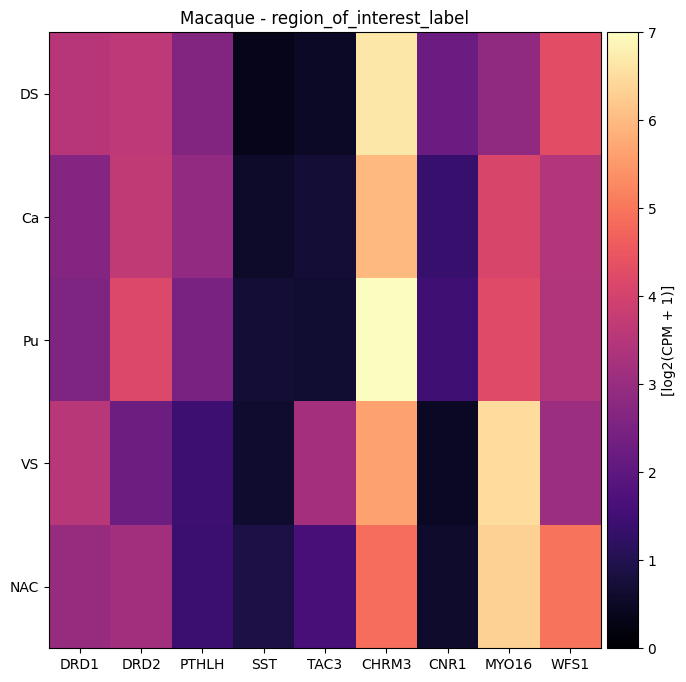

In [11]:
macaque_gene_names = ['DRD1', 'DRD2', 'PTHLH', 'SST', 'TAC3', 'CHRM3', 'CNR1', 'MYO16', 'WFS1']

feature_name = "region_of_interest_label"
agg = aggregate_by_metadata(macaque_cell_metadata_with_genes, macaque_gene_names, feature_name)
# We drop ic here as it has a very small number or cells.
plot_heatmap(agg.drop('ic'), 8, 8, vmin=0, vmax=7) # vmin and vmax set based on observed expression ranges
plt.title(f'Macaque - {feature_name}')
plt.show()

## Taxonomy mapping

Finally, let's load the taxonomy information so that we can plot gene expression versus various taxons in a heatmap for each species. Below, we load and merge all the information we need to plot cell colors and taxonomy as done in the previous [HMBA tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html).

In [12]:
cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)
membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'],
    inplace=True
)

The macaque patch-seq gene expression has been mapped to the HMBA-BG taxonomy using MapMyCells, excluding non-neuronal nodes. We load this table below. A more lightweight version of this table with only mappings between cells to cluster_alias. The table is named `cell_to_cluster_membership`.

Below we load the complete MMC results with probabilities and correlation coefficients for all assignments at all levels.

In [13]:
macaque_mmc = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq',
    file_name='mmc_results',
).set_index('cell_label')
macaque_mmc.head()

mmc_results.csv: 100%|██████████| 201k/201k [00:00<00:00, 1.42MMB/s] 


,Neighborhood_label,Neighborhood_name,Neighborhood_bootstrapping_probability,Neighborhood_aggregate_probability,Neighborhood_correlation_coefficient,Class_label,Class_name,Class_bootstrapping_probability,Class_aggregate_probability,Class_correlation_coefficient,...,Group_label,Group_name,Group_bootstrapping_probability,Group_aggregate_probability,Group_correlation_coefficient,Cluster_label,cluster_alias,Cluster_bootstrapping_probability,Cluster_aggregate_probability,Cluster_correlation_coefficient
cell_label,,,,,,,,,,,,,,,,,,,,,
QN22.26.002.14.05.04,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.7190,CS20250428_CLASS_0003,CN LGE GABA,1.0,1.0,0.7093,...,CS20250428_GROUP_0054,STRd D2 Striosome MSN,1.00,1.00,0.5715,CS20250428_CLUST_0986,Macaque-429,1.00,1.0000,0.5615
QN22.26.002.14.05.05,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.7634,CS20250428_CLASS_0003,CN LGE GABA,1.0,1.0,0.7466,...,CS20250428_GROUP_0049,STRd D1 Matrix MSN,1.00,1.00,0.6477,CS20250428_CLUST_0949,Macaque-467,0.99,0.9900,0.5517
QN22.26.002.14.05.06,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6603,CS20250428_CLASS_0003,CN LGE GABA,1.0,1.0,0.6376,...,CS20250428_GROUP_0054,STRd D2 Striosome MSN,1.00,1.00,0.4564,CS20250428_CLUST_0986,Macaque-429,0.62,0.6200,0.4341
QN22.26.002.14.05.08,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6162,CS20250428_CLASS_0003,CN LGE GABA,1.0,1.0,0.5980,...,CS20250428_GROUP_0052,STRd D2 Matrix MSN,0.88,0.88,0.4317,CS20250428_CLUST_0973,Macaque-465,1.00,0.8800,0.4515
QN22.26.002.14.05.09,CS20250428_NEIGH_0002,Subpallium GABA,1.0,1.0,0.6987,CS20250428_CLASS_0003,CN LGE GABA,1.0,1.0,0.6847,...,CS20250428_GROUP_0049,STRd D1 Matrix MSN,0.99,0.99,0.5025,CS20250428_CLUST_0949,Macaque-467,0.57,0.5643,0.3415


In [14]:
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(macaque_mmc)
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(cluster_details, on='cluster_alias')
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(cluster_colors, on='cluster_alias', rsuffix='_color')
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(cluster_order, on='cluster_alias')

macaque_cell_metadata_with_genes.head()

,library_label,library_aliquot_label,barcoded_cell_sample_label,donor_label,dataset_label,feature_matrix_label,alignment_id,donor_age_value,donor_age_unit,age_at_death_reference_point,...,Neighborhood_color,Class_color,Subclass_color,Group_color,Cluster_color,Class_order,Cluster_order,Group_order,Neighborhood_order,Subclass_order
cell_label,,,,,,,,,,,,,,,,,,,,,
QN22.26.002.14.05.04,L8S4_220222_04_H05,AB-S40302_S424_E1-50,P4S4_220131_155_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710839,15,years,birth,...,#19613b,#d0b83c,#253c8c,#ff9896,#561430,10,1290,55,3,32
QN22.26.002.14.05.05,L8S4_220222_04_A06,AB-S40302_S425_E1-50,P4S4_220131_156_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710837,15,years,birth,...,#19613b,#d0b83c,#1655f2,#1f77b4,#b83642,10,1059,50,3,31
QN22.26.002.14.05.06,L8S4_220222_04_B06,AB-S40302_S426_E1-50,P4S4_220131_157_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710836,15,years,birth,...,#19613b,#d0b83c,#253c8c,#ff9896,#561430,10,1290,55,3,32
QN22.26.002.14.05.08,L8S4_220222_04_C06,AB-S40302_S427_E1-50,P4S4_220131_158_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710835,15,years,birth,...,#19613b,#d0b83c,#253c8c,#aec7e8,#d71b39,10,1194,53,3,32
QN22.26.002.14.05.09,L8S4_220222_04_D06,AB-S40302_S428_E1-50,P4S4_220131_159_A01,QN22.26.002,HMBA-Macaque-PatchSeq,HMBA-Macaque-PatchSeq-BG,1200710834,15,years,birth,...,#19613b,#d0b83c,#1655f2,#1f77b4,#b83642,10,1059,50,3,31


### Visualize gene expression for selected genes by the HMBA-BG taxonomy

Below we plot the gene expression for the cells as a function the Group level in the taxonomy they were associated with. We plot the MSNs cell-types only. We'll also use a subset of the genes we extracted from the gene expression matrix.

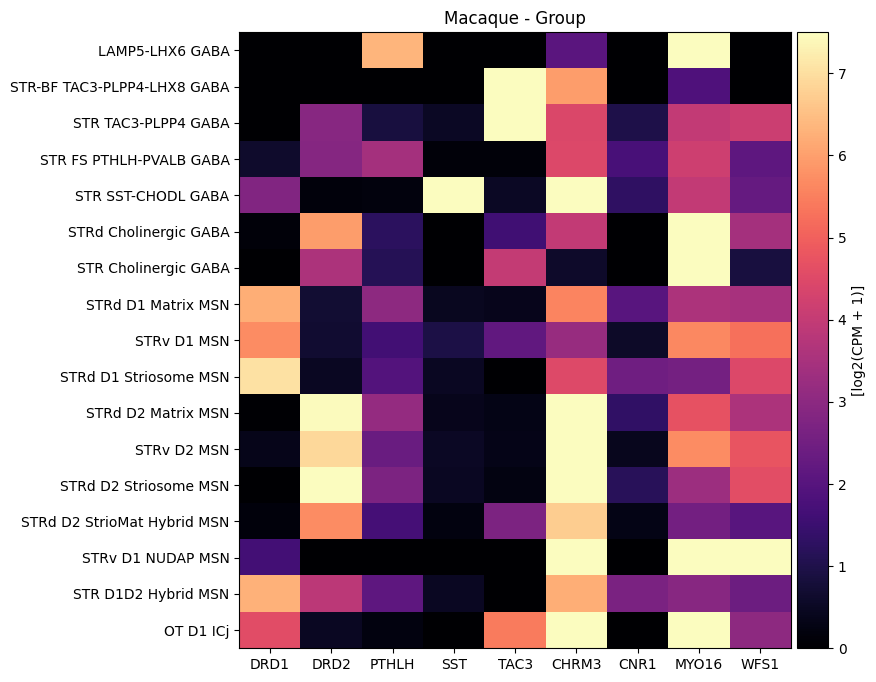

In [15]:
macaque_gene_names = ['DRD1', 'DRD2', 'PTHLH', 'SST', 'TAC3', 'CHRM3', 'CNR1', 'MYO16', 'WFS1']

feature_name = "Group"
agg = aggregate_by_metadata(
    macaque_cell_metadata_with_genes,
    macaque_gene_names,
    feature_name
)


plot_heatmap(agg, 8, 8, vmin=0, vmax=7.5)
plt.title(f'Macaque - {feature_name}')
plt.show()

## Other Features

In addition to gene expression, we also look at electrophysiology and morphology features.

### Electrophysiological features

The electrophysiological features are across 4 tables: ap_features, chirp_features, cross_sweep_long_square_features, and sweep_features. In the below example, we load the ap_features table and merge it into our cell_metadata table.

A full list of the electrophysiological features with some short descriptions can be downloaded [here](https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/metadata/HMBA-Macaque-PatchSeq/20260228/electrophysiological_feature_lookup.xlsx)

In [16]:
ap_features = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq', file_name='ap_features'
).set_index('cell_label')

# most cells have no measurement for these features so we filter those with values just to see what the data looks like. 
ap_features[pd.notna(ap_features['adp_v_last_rheo'])].head()

ap_features.csv: 100%|██████████| 496k/496k [00:00<00:00, 3.00MMB/s] 


,adp_v_last_rheo,ahp_delay_5spike,ahp_delay_hero,ahp_delay_ratio_5spike,ahp_delay_ratio_hero,downstroke_adapt_ratio,downstroke_hero,downstroke_ramp,downstroke_rheo,downstroke_short_square,...,width_adapt_ratio,width_hero,width_ramp,width_rheo,width_rheo_ms,width_short_square,width_suprathresh_hero,width_suprathresh_ramp,width_suprathresh_rheo,width_suprathresh_short_square
cell_label,,,,,,,,,,,,,,,,,,,,,
Q21.26.003.12.03.01,-55.000004,0.021870,0.000980,0.191146,0.034789,0.879896,-267.810016,NaN,-256.109021,-277.295319,...,1.090909,0.000375,NaN,0.000385,0.385,0.000370,0.000345,NaN,0.000355,0.000335
Q21.26.006.14.01.04,-50.093750,0.043635,0.043635,0.237018,0.237018,0.879694,-87.819662,NaN,-88.143416,-99.554269,...,1.086124,0.001045,NaN,0.001055,1.055,0.000935,0.000945,NaN,0.000955,0.000850
Q21.26.009.12.01.03,-51.000004,0.155950,0.001390,0.483124,0.066763,0.900912,-179.379158,NaN,-169.956722,-191.220558,...,1.070707,0.000475,NaN,0.000485,0.485,0.000460,0.000430,NaN,0.000455,0.000415
Q21.26.009.12.02.03,-61.062504,0.030185,0.026850,0.120473,0.188131,0.789810,-72.779128,NaN,-69.267846,-80.596543,...,1.152610,0.001270,NaN,0.001305,1.305,0.001220,0.001175,NaN,0.001185,0.001125
Q21.26.009.12.01.04,-52.812500,0.037275,0.026275,0.250311,0.255842,0.982069,-73.422130,NaN,-71.413402,-79.772097,...,1.101770,0.001120,NaN,0.001140,1.140,0.001085,0.001045,NaN,0.001050,0.000990


In [17]:
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(ap_features)

Below, we create a function to create a box plot for a given feature by e.g. a taxonomy level, ROI structure, etc.

In [18]:
def plot_boxplot_by_column(
        dataframe, col_name, value_col
    ):
    """
    Plots a boxplot of the specified value column grouped by the specified column.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input dataframe containing the data to plot.
    col_name : str
        The name of the column to group by.
    value_col : str
        The name of the column containing the values to plot.
    """
    box_values = {}
    for group in dataframe[col_name].unique()[
            np.argsort(dataframe[f"{col_name}_order"].unique()) # Order by the specified order column
    ]:
        col_values = dataframe.loc[dataframe[col_name] == group, value_col]
        if pd.notna(col_values).sum() > 0:
            box_values[group] = col_values[~col_values.isna()].values # Use non-NA values for the boxplot

    plt.boxplot(
        box_values.values()
    )
    plt.xticks(
        ticks=np.arange(1, len(box_values) + 1),
        labels=box_values.keys(),
        rotation=90
    )
    plt.ylabel(value_col)
    plt.title(f'{value_col} by {col_name}')
    plt.show()

We'll plot the ephys feature, `width_rheo` in a boxplot against the Groups in this dataset.

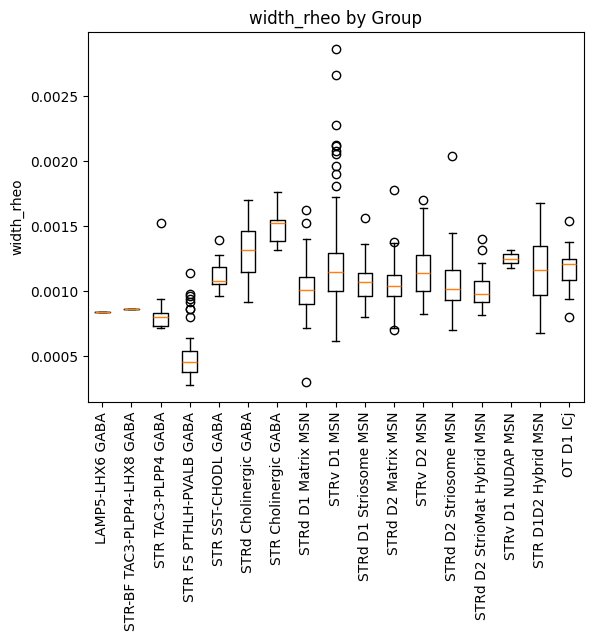

In [19]:
plot_boxplot_by_column(dataframe=macaque_cell_metadata_with_genes, col_name='Group', value_col='width_rheo')

### Morphological Features

We now load our morphological features and merge them into the cell metadata. A full list of the morphological features with short descriptions can be downloaded [here](https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/metadata/HMBA-Macaque-PatchSeq/20260228/morphology_features.csv).

In [20]:
morphology_features = abc_cache.get_metadata_dataframe(
    directory='HMBA-Macaque-PatchSeq', file_name='morphology_features'
).set_index('cell_label')
morphology_features.head()

morphology_features.csv: 100%|██████████| 97.4k/97.4k [00:00<00:00, 642kMB/s] 


,23_Sholl_PC0,23_Sholl_PC1,2_Sholl_PC0,2_Sholl_PC1,3_Sholl_PC0,3_Sholl_PC1,axon_bias_dorsal,axon_bias_medial,axon_exit_distance,axon_exit_theta_coronal,...,basal_dendrite_mean_diameter,basal_dendrite_num_branches,basal_dendrite_soma_percentile_dorsal,basal_dendrite_soma_percentile_medial,basal_dendrite_stem_exit_MedialLateral,basal_dendrite_stem_exit_dorsal,basal_dendrite_stem_exit_ventral,basal_dendrite_total_length,basal_dendrite_total_surface_area,soma_surface_area
cell_label,,,,,,,,,,,,,,,,,,,,,
Q19.26.014.11.04.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q19.26.014.11.01.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q19.26.014.11.01.04,NaN,NaN,NaN,NaN,168.820400,29.150249,NaN,NaN,NaN,0.667150,...,0.573221,56.0,0.468694,0.334369,0.5,0.125,0.375,5241.027500,9442.031612,548.486434
Q19.26.014.11.01.05,NaN,NaN,NaN,NaN,282.741349,-36.067186,NaN,NaN,NaN,0.875211,...,0.565709,69.0,0.489853,0.428372,0.4,0.200,0.400,5909.886270,10526.672804,359.438955
Q19.26.014.11.05.01,NaN,NaN,NaN,NaN,276.829831,-84.814559,NaN,NaN,NaN,0.447964,...,0.609324,77.0,0.576005,0.407282,0.8,0.200,0.000,5946.308781,11421.095519,502.026310


In [21]:
macaque_cell_metadata_with_genes = macaque_cell_metadata_with_genes.join(morphology_features)

Finally, we plot the soma surface area feature against the taxonomy Group.

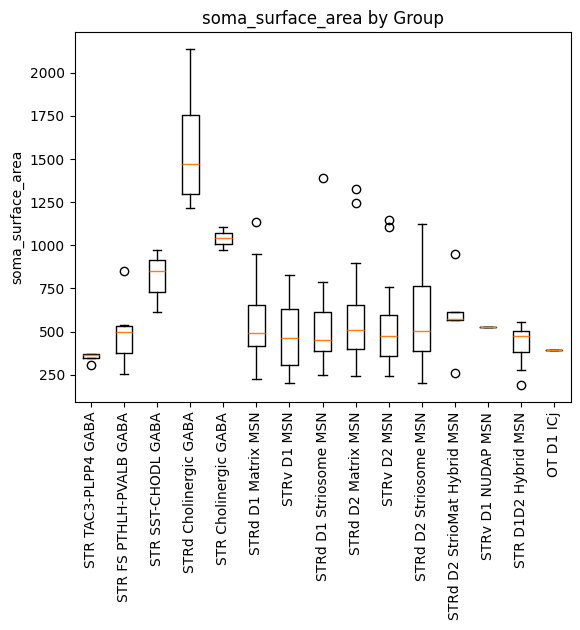

In [22]:
plot_boxplot_by_column(dataframe=macaque_cell_metadata_with_genes, col_name='Group', value_col='soma_surface_area')

To learn more about the spatial transcriptomic data see the [HMBA-BG Spatial Slabs and Taxonomy notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_spatial_slabs_and_taxonomy.html).

To learn more about the taxonomy used in this notebook and the data it is derived from, see the [HMBA-BG Clustering Analysis and Taxonomy notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html).